Deep Learning for NLP
Fake news classifier: Train a text classification model to detect fake news articles!

Download the dataset here: https://www.kaggle.com/datasets/sadikaljarif/fake-news-detection-dataset-english (if you'd like, you can also look at fake news datasets in other languages, which are available on the Huggingface Hub)
Develop an NLP model for classification that uses a pretrained language model and the text of the article. It should NOT use the URL
Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice.
Upload the the model to the Hugging Face Hub, and add a link to your model below.
Answer the following question: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

Link to huggingface:  

In [1]:
#Mounting the google drive and the folder where I have my data dowloaded from the link shared above.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/fatima_challenge/

/content/gdrive/MyDrive/fatima_challenge


In [3]:
! pip install transformers
! pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


fake_data = pd.read_csv('fake_news_data/Fake.csv')
true_data = pd.read_csv('fake_news_data/True.csv')


# Labelling the calsses
fake_data["label"] = "incorrect"
true_data["label"] = "correct"

# Combining both types of data
all_data = pd.concat([fake_data,true_data])

# shuffling the data
all_data = all_data.sample(frac=1).reset_index(drop = True) 
all_data['text'] = all_data['title'] + all_data['text']
all_data = all_data[['text','label']]
all_data['label'] = all_data['label'].map({'incorrect':0,'correct':1})
all_data.head()

# preparing data for model
data_text=all_data["text"]
data_label=all_data["label"]


print('Mean Length of String: ', all_data['text'].str.len().mean())
maxlen=100

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')




X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)


def tokenize(X):
    
    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model


<ipython-input-4-ebcd81b3884d>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['label'] = all_data['label'].map({'incorrect':0,'correct':1})


Mean Length of String:  2549.221412980534


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [6]:
model=create_model()
model.summary()

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

history = model.fit(x = {'input_1':X_train_token['input_ids'],'input_2':X_train_token['attention_mask']}, y = Y_train,
                    epochs=5, validation_split = 0.2, batch_size = 30, callbacks=[callback])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [7]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


281/281 [==============================] - 68s 227ms/step


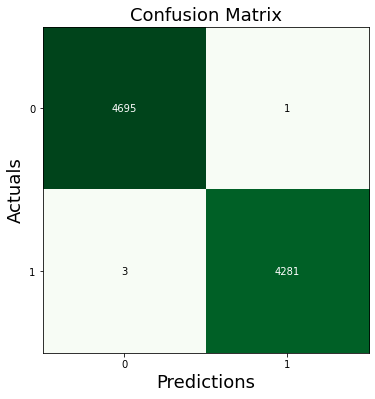

In [8]:
y_pred = np.where(model.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}) >=0.5,1,0)
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

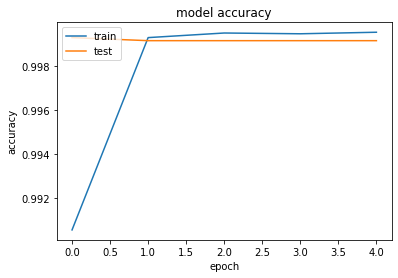

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

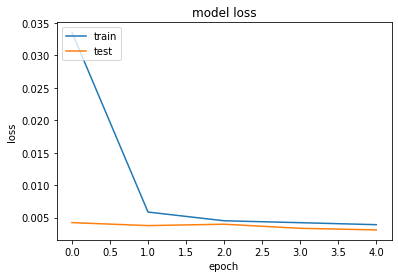

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

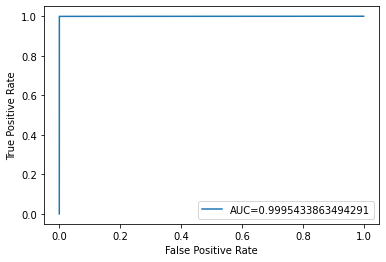

In [11]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred)
auc = metrics.roc_auc_score(Y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [12]:
print("Accuracy", metrics.accuracy_score(Y_test, y_pred))

Accuracy 0.999554565701559
